# Omniglot MAML Implementation by Divyam(divyam096@gmail.com)
##This notebook addresses the one-shot classification (20-way) challenge on the Omniglot dataset as stated on https://fellowship.ai/challenge


###To complete the setup of the colab notebook, please follow the following steps:


1.   Change the runtime of the colab notebook to GPU (Runtime->Change runtime type -> select Python 3 AND GPU).
2.   Please upload the epoch145_accuracy0.93125.pth, util.py, maml_cnn.py and demo_classification.py files to the current working directory(/content/.). You can find these files on extracting the zip file i have submitted.
3.    Please run the below cell to download the necessary Omniglot data to train our models.



In [0]:
#@title Run this cell to download the Omniglot background and evaluation datasets necessary to train our meta learner.
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip
!wget https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip
!unzip images_background.zip
!unzip images_evaluation.zip
!mkdir -p models/maml

The code that defines the OmniglotMamlKwayNshot class can be found in the succeeding cells. Here we define a meta learner(self.__meta_learner) that comprises of a CNN built with 6 convolution blocks followed by a single layer MLP classifier.  Here each convolution block is defined by a sequence of a 3x3 conv filter, batch normalization layer, a ReLU activation, and a 2d Max pooler.  

The  member function that is responsible for training the meta learner is the fit() function. 
This function implements the "Algorithm 2 MAML for Few-Shot Supervised Learning" as suggested by the Chelsea-Pieter-Sergey paper(https://arxiv.org/pdf/1703.03400.pdf). The algorithm can be seen below

<img src ="https://image.slidesharecdn.com/maml-181130144044/95/introduction-to-maml-model-agnostic-meta-learning-with-discussions-19-638.jpg?cb=1543588892">

The fit() function accepts a batch of tasks(T<sub>i</sub>) as input and iterates over each task. Now each tasks is further sampled into support batch(D) and a query batch(D'). The support batch is used to train the fast model. A fast model can be any model that can be optimized by gradient descent. Here for the sake of convenience, we use the same CNN architecture that is used to create the meta learner. Now the query points(D') and the loss from the fast model is used to train the meta learner as shown in the algorithm to find an ideal  &Theta;.

The eval() function works in a similar manner but aims to train the fast model to adjust to an appropriate  &Theta;<sub>1</sub>/&Theta;<sub>2</sub>/&Theta;<sub>3</sub>* which are then used to compute the predicted class for each query point in D'.

In [0]:
from collections import OrderedDict

import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torch import nn

from maml_cnn import MamlCNN
from util import OmniglotDataset, NShotTaskSampler, create_nshot_task_label, categorical_accuracy

In [0]:
class OmniglotMamlKwayNshot:

    def __init__(self, k_way, n_shot, num_queries, num_tasks_per_batch, path=None):
        """
        Class that defines the necessary models and functions to train the meta learner on the
        Omniglot data set using the MAML(Model-Agnostic Meta-Learning ) approach.

        :param k_way: int Number of possible classes in each query
        :param n_shot: int Number of support data points for training each class
        :param num_queries: int Number of queries for each class
        :param num_tasks_per_batch: int Number of tasks for each batch in data set.
        :param path: str Absolute path to an existing model(optional)
        """

        self.k = k_way
        self.n = n_shot
        self.q = num_queries
        self.num_tasks = num_tasks_per_batch
        self.device = self.get_device_type()
        self.loss_fn = nn.CrossEntropyLoss().to(self.device)
        self.epoch = 0

        self.__meta_learner = self.load_model(k_way=self.k, path=path)
        self.__meta_learner.to(self.device, dtype=torch.double).train()
        self.__meta_optimiser = torch.optim.Adam(self.__meta_learner.parameters(), lr=0.001)
        self.__results = self._init_results_dict()

    def fit(self, tasks):
        """

        :param tasks: Tensor containing the tasks the meta learner needs to be trained upon.
        :return:
        """
        task_losses = []

        for task in tasks:
            x_fast_train, x_meta_train = self._sample_data(task)

            fast_weights = self._train_fast_model(x_fast_train, epochs=1, create_graph=True)

            y = create_nshot_task_label(self.k, self.q).to(self.device)
            logits = self.__meta_learner.functional_forward(x_meta_train, fast_weights)
            loss = self.loss_fn(logits, y)
            task_losses.append(loss)

        self.__meta_learner.train()
        self.__meta_optimiser.zero_grad()
        meta_batch_loss = torch.stack(task_losses).mean()
        meta_batch_loss.backward()
        self.__meta_optimiser.step()
        self.__results["train"][self.epoch] += meta_batch_loss.item()

    def eval(self, tasks):
        """

        :param tasks: Tensor containing the tasks the meta learner needs to be evaluated upon.
        :return:
        """
        y_softmax_batch = []

        for task in tasks:
            support_data, query_data = self._sample_data(task)

            fast_weights = self._train_fast_model(x_fast_train=support_data, epochs=1, create_graph=False)

            logits = self.__meta_learner.functional_forward(query_data, fast_weights)
            y_softmax = logits.softmax(dim=1)
            y_softmax_batch.append(y_softmax)

        y_softmax_batch_tensor = torch.cat(y_softmax_batch)
        return y_softmax_batch_tensor


    def run_epoch(self, train_batches, val_batches):
        """
        Primary function that defines an epoch.
        An epoch involves:
         1) Training step responsible for training the meta learner.
         2) Validation step responsible for measuring the performance of the trained model

        :param train_batches: DataLoader object responsible for generating training batches
        :param val_batches: DataLoader object responsible for
        :return:
        """
        self._init_epoch()

        self.fit_model(train_batches) # Training step
        self.evaluate_model(val_batches) # Validation step

        self._publish_epoch_results()

    def fit_model(self, train_batches):
        """
        Function to fit the meta learner on batches of training tasks.

        :param train_batches: DataLoader object responsible for generating training batches
        :return:
        """

        for batch_index, batch in enumerate(train_batches):
            training_tasks, y = self._get_tasks(batch)
            self.fit(training_tasks)

    def evaluate_model(self, val_batches):
        """
        Function to evaluate the meta learner on batches of validation tasks.

        :param val_batches: DataLoader object responsible for generating validation batches
        :return:
        """
        for batch_index, batch in enumerate(val_batches):
            validation_tasks, y = self._get_tasks(batch)
            y_softmax_batch = self.eval(validation_tasks)
            self._update_batch_accuracies(batch_index, y, y_softmax_batch)
        self._update_total_accuracies()


    def _train_fast_model(self, x_fast_train, epochs, create_graph):
        """
        Function to train the fast model on the support data points

        :param x_fast_train: k*n Tensor of support data points
        :param epochs: int number of epochs to train the fast model for
        :param create_graph: bool defines wheteher second order derivatives will be involved
        :return:
        """

        fast_weights = OrderedDict(self.__meta_learner.named_parameters())

        for inner_batch in range(epochs):
            y = create_nshot_task_label(self.k, self.n).to(self.device)
            logits = self.__meta_learner.functional_forward(x_fast_train, fast_weights)
            loss = self.loss_fn(logits, y)
            gradients = torch.autograd.grad(loss, fast_weights.values(), create_graph=create_graph)

            fast_weights = OrderedDict(
                (name, param - 0.4 * grad)
                for ((name, param), grad) in zip(fast_weights.items(), gradients)
            )
        return fast_weights

    def _sample_data(self, task):
        """
        Function to sample a task into support and query data.

        :param task: Tesnsor that contains the support and query data for each internal training/evaluation step.
        :return:
        """
        support_data = task[:self.n * self.k]
        query_data = task[self.n * self.k:]
        return support_data, query_data

    def _get_tasks(self, batch):
        """
        Transform a batch of sorted images into tasks where each task contains k*n support data points
        and k*q query data points.

        :param batch: Tensor that defines a batch as returned by the DataLoader
        :return: list of tasks, list of labels
        """
        x, y = batch
        x = x.reshape(self.num_tasks, self.n * self.k + self.q * self.k, 1, x.shape[-2], x.shape[-1])
        x = x.double().to(self.device)
        y = create_nshot_task_label(self.k, self.q).to(self.device).repeat(self.num_tasks)
        return x, y

    def _init_results_dict(self):
        """

        :return: dict Empty dictionary to record the performance of each epoch
        """
        results = dict(train=OrderedDict(),
                       accuracy=OrderedDict(),
                       current_batch_accuracies=OrderedDict())
        return results

    def _init_epoch(self):
        """
        Prepare the results dictionary for the upcoming epoch

        :return:
        """
        self.__results["train"][self.epoch] = 0
        self.__results["accuracy"][self.epoch] = 0
        self.__results["current_batch_accuracies"] = OrderedDict()
        print(f"-----------Epoch{self.epoch}-----------")

    def _update_batch_accuracies(self, batch_index, y, y_softmax_batch):
        """

        :param batch_index: int batch index to identify the batch number
        :param y: Tensor containng the class number each data point in the batch belongs to.
        :param y_softmax_batch: Tensor softmax confidence levels for each class
        :return:
        """
        self.__results["current_batch_accuracies"][batch_index] = categorical_accuracy(y, y_softmax_batch)

    def _update_total_accuracies(self):
        """
        Function to record validation accuracies for the current epoch.
        :return:
        """
        self.__results["accuracy"][self.epoch] = sum(self.__results["current_batch_accuracies"].values())/\
                                                     len(self.__results["current_batch_accuracies"].values())


    def _publish_epoch_results(self):
        """
        Function that handles the post epoch tasks like saving models and publishing epoch results to stdout

        :return:
        """
        accuracy = self.__results["accuracy"][self.epoch]
        torch.save(self.__meta_learner.state_dict(), f'/content/models/maml/epoch{self.epoch}_accuracy{accuracy}.pth')
        print("Total train loss:", self.__results["train"][self.epoch])
        print("Validation accuracy: ", self.__results["accuracy"][self.epoch])
        self.epoch += 1

    def plot_training_loss(self):
        """
        Function to plot training loss vs epochs

        :return:
        """
        plt.plot(self.__results["train"].keys(), self.__results["train"].values())
        plt.xlabel('epochs')
        plt.ylabel('Training Loss')

    def plot_validation_accuracy(self):
        """
        Function to plot validation accuracy vs epochs

        :return:
        """
        plt.plot(self.__results["accuracy"].keys(), self.__results["accuracy"].values())
        plt.xlabel('epochs')
        plt.ylabel('Validation Accuracy')

    @staticmethod
    def get_device_type():
        """
        Function to detect device type

        :return: device type
        """
        return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    @staticmethod
    def load_model(k_way, path=None):
        """
        Function to load a pre existing model into the Meta learner CNN if it exists and create a new one

        :param k_way: Number of classes the model is supposed to discriminate between.
        :param path: Absolute path to an existing model
        :return: MamlCNN neural net that is to be used for the k way nshot classification task
        """
        meta_learner = MamlCNN(num_input_channels=1, k_way=k_way, final_layer_size=64)
        if path:
            meta_learner.load_state_dict(torch.load(path))
        return meta_learner

    @staticmethod
    def load_data(background_datset_path, evaluation_dataset_path):
        """
        Function to load the Omniglot dataset

        :param background_datset_path:
        :param evaluation_dataset_path:
        :return:
        """
        background = OmniglotDataset('background', path=background_datset_path)
        evaluation = OmniglotDataset('evaluation', path=evaluation_dataset_path)
        return background, evaluation

    @staticmethod
    def get_task_batches_from_dataset(dataset, k, n, q, num_tasks, num_batches):
        """

        :param dataset: Omniglot Dataset that is to be broken down into batches
        :param k: int number of classes
        :param n: int number of support data points for each class
        :param q: int number of query data points for each class
        :param num_tasks: int number of tasks per batch
        :param num_batches: number of batches to be generated
        :return: generator that generates batches from the dataset
        """
        batches = DataLoader(dataset,
                             batch_sampler=NShotTaskSampler(dataset, num_batches, n=n, k=k, q=q, num_tasks=num_tasks),
                             num_workers=8)
        return batches



In [0]:
omniglot_20 = OmniglotMamlKwayNshot(k_way=20, n_shot=1, num_queries=1,
                                num_tasks_per_batch=6)

In [0]:
background, evaluation = OmniglotMamlKwayNshot.load_data(background_datset_path="/content/images_background",
                                                       evaluation_dataset_path="/content/images_evaluation")

Indexing background...
Indexing evaluation...


In [0]:
train_batches = OmniglotMamlKwayNshot.get_task_batches_from_dataset(dataset=background,
                                    k=omniglot_20.k, n=omniglot_20.n, q=omniglot_20.q, num_tasks=omniglot_20.num_tasks, num_batches=50)
validation_batches = OmniglotMamlKwayNshot.get_task_batches_from_dataset(dataset=evaluation,
                                    k=omniglot_20.k, n=omniglot_20.n, q=omniglot_20.q, num_tasks=omniglot_20.num_tasks, num_batches=20)

In [0]:
for epoch in range(25):
  omniglot_20.run_epoch(train_batches=train_batches, val_batches=validation_batches)

-----------Epoch0-----------
Total train loss: 135.68102197351928
Validation accuracy:  0.275
-----------Epoch1-----------
Total train loss: 109.38840980208664
Validation accuracy:  0.5195833333333334
-----------Epoch2-----------
Total train loss: 76.80122085094621
Validation accuracy:  0.6283333333333334
-----------Epoch3-----------
Total train loss: 55.32148372540149
Validation accuracy:  0.7354166666666666
-----------Epoch4-----------
Total train loss: 41.966428334065995
Validation accuracy:  0.7529166666666667
-----------Epoch5-----------
Total train loss: 32.04028733280768
Validation accuracy:  0.7954166666666667
-----------Epoch6-----------
Total train loss: 26.964144254729124
Validation accuracy:  0.8220833333333333
-----------Epoch7-----------
Total train loss: 22.148336699560392
Validation accuracy:  0.8408333333333331
-----------Epoch8-----------
Total train loss: 20.89852030806977
Validation accuracy:  0.8620833333333332
-----------Epoch9-----------
Total train loss: 17.7909

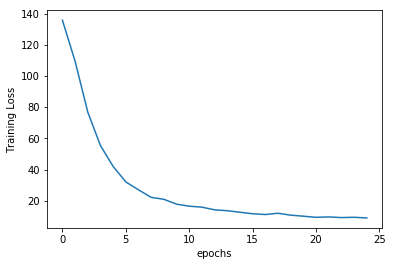

In [0]:
omniglot_20.plot_training_loss()

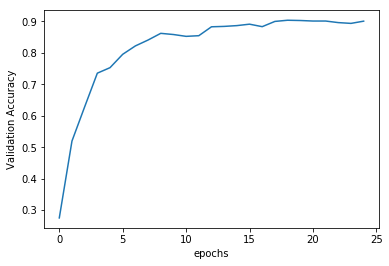

In [0]:
omniglot_20.plot_validation_accuracy()


#Testing Phase

In [0]:
#@title Run this cell to download the Omniglot test set to evaluate the performance of our meta learner.
!wget https://github.com/brendenlake/omniglot/raw/master/python/one-shot-classification/all_runs.zip
!unzip all_runs.zip

In [0]:
from demo_classification import main

Please uncomment the below code in order to use a pretrained model.

In [0]:
# omniglot_20 = OmniglotMamlKwayNshot(k_way=20, n_shot=1, num_queries=1,
#                                 num_tasks_per_batch=6, path='/content/epoch145_accuracy0.93125.pth')

main(maml=omniglot_20)

One-shot classification demo with Modified Hausdorff Distance


/usr/local/lib/python3.6/dist-packages/skimage/io/_io.py:53: UserWarning: `flatten` has been deprecated in favor of `as_gray` and will be removed in v0.16.
  warn('`flatten` has been deprecated in favor of `as_gray`'


 run 1 (error 45.0%)
 run 2 (error 35.0%)
 run 3 (error 40.0%)
 run 4 (error 25.0%)
 run 5 (error 30.0%)
 run 6 (error 15.0%)
 run 7 (error 60.0%)
 run 8 (error 35.0%)
 run 9 (error 40.0%)
 run 10 (error 55.0%)
 run 11 (error 15.0%)
 run 12 (error 70.0%)
 run 13 (error 65.0%)
 run 14 (error 35.0%)
 run 15 (error 15.0%)
 run 16 (error 25.0%)
 run 17 (error 30.0%)
 run 18 (error 40.0%)
 run 19 (error 70.0%)
 run 20 (error 30.0%)
 average error 38.75%
One-shot classification demo with MAML
 run 1 (error 0.0%)
 run 2 (error 10.0%)
 run 3 (error 15.0%)
 run 4 (error 5.0%)
 run 5 (error 10.0%)
 run 6 (error 0.0%)
 run 7 (error 5.0%)
 run 8 (error 15.0%)
 run 9 (error 25.0%)
 run 10 (error 25.0%)
 run 11 (error 10.0%)
 run 12 (error 10.0%)
 run 13 (error 10.0%)
 run 14 (error 10.0%)
 run 15 (error 10.0%)
 run 16 (error 0.0%)
 run 17 (error 25.0%)
 run 18 (error 35.0%)
 run 19 (error 30.0%)
 run 20 (error 20.0%)
 average error 13.5%


###Quite clearly our newly trained model performs considerably better as compared to the default Modified Hausdorff Distance approach. Better performances can be achived by training the model over a longer period of time.

##Credits:
Oscar Knagg for his kickass blog